In [1]:
%matplotlib inline

import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

import sys, pickle
sys.path.append('../')
from crowd_nav.utils.memory import ReplayMemory
from crowd_nav.utils.pytorchtools import EarlyStopping

In [2]:
# class autoencoder(nn.Module):
#     def __init__(self, num_human, drop_rate=0.00):
#         super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(num_human * 4, 128),
#             nn.ReLU(True),
#             nn.Dropout(drop_rate),
#             nn.Linear(128, 64),
#             nn.ReLU(True),nn.Dropout(drop_rate), nn.Linear(64, 12))
#         self.decoder = nn.Sequential(
#             nn.Linear(12, 64),
#             nn.ReLU(True),
#             nn.Dropout(drop_rate),
#             nn.Linear(64, 128),
#             nn.ReLU(True),nn.Dropout(drop_rate), nn.Linear(128, num_human * 2))

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x
    
class autoencoder(nn.Module):
    def __init__(self, num_human, drop_rate=0.00):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_human * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12))
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, num_human * 2))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
dataset=0
with open(r"data/sarl5/rawob.data", "rb") as input_file:
    dataset = pickle.load(input_file)
    
num_human=5
drop_rate=0.25
num_epochs = 1000000
batch_size = 10
learning_rate = 1e-3
train_size=int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
patience = 7

train_loader = DataLoader(dataset[:train_size], batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset[train_size:train_size+val_size], batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset[train_size+val_size:], batch_size=batch_size, shuffle=False)

early_stopping = EarlyStopping(patience = patience)
train_losses = []
valid_losses = []

In [11]:
#-------------  Training world model --------------
model = autoencoder(num_human,drop_rate).cuda()
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        # State , Action , Next State, Reward
        x,_,y,_ = data
        y = y[:,:,:2]
        x = x.view(x.size(0), -1)
        x = Variable(x).cuda()
        y = Variable(y).cuda()
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, y.view(y.size(0), -1))
        train_losses.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    # ===================log========================
    
    model.eval()
    for data in val_loader:
        x,_,y,_ = data
        y = y[:,:,:2]
        x = x.view(x.size(0), -1)
        x = Variable(x).cuda()
        y = Variable(y).cuda()
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, y.view(y.size(0), -1))
        valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    
    print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss, valid_loss))
    train_losses = []
    valid_losses = []
    early_stopping(valid_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
print("Best Val loss: {:.4f}".format (early_stopping.val_loss_min))

epoch [1/1000000], train_loss:3.4956, val_loss:3.5247
epoch [2/1000000], train_loss:2.8431, val_loss:3.1096


KeyboardInterrupt: 

In [5]:
#-------------  Testing world model --------------
model = autoencoder(num_human,drop_rate).cuda()
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
test_losses = []
for data in test_loader:
    x,_,y,_ = data
    y = y[:,:,:2]
    x = x.view(x.size(0), -1)
    x = Variable(x).cuda()
    y = Variable(y).cuda()
    # ===================forward=====================
    output = model(x)
    loss = criterion(output, y.view(y.size(0), -1))
    test_losses.append(loss.item())

test_loss = np.average(test_losses)
print('test_loss:{:.4f}'.format(test_loss))

test_loss:0.3238


In [4]:
def render(states, radius): 
    time_step = 0.25
    colors=['blue',"red",'green','y','black']
    fig, ax = plt.subplots(figsize=(10, 10))   
    # canvas = FigureCanvas(fig)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    for i,state in enumerate(states):
        for j, human in enumerate(state):
            human_circle = plt.Circle(human[:2], radius, fill=False, color=colors[j])
            ax.add_artist(human_circle)
            if i>0:
                l_px, l_py = states[i-1][j]
                vx, vy = (human[0] - l_px)/time_step, (human[1] - l_py)/time_step
                arrow = plt.arrow(human[0],human[1], 
                              vx, vy , color=colors[j])
                ax.add_artist(arrow)
    plt.show()
    
def render_truth(states, radius): 
    colors=['blue',"red",'green','y','black']
    fig, ax = plt.subplots(figsize=(10, 10))   
    # canvas = FigureCanvas(fig)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    for i,state in enumerate(states):
        for j, human in enumerate(state):
            human_circle = plt.Circle(human[:2], radius, fill=False, color=colors[j])
            ax.add_artist(human_circle)
            arrow = plt.arrow(human[0],human[1], 
                          human[2],human[3] , color=colors[j])
            ax.add_artist(arrow)
    plt.show()

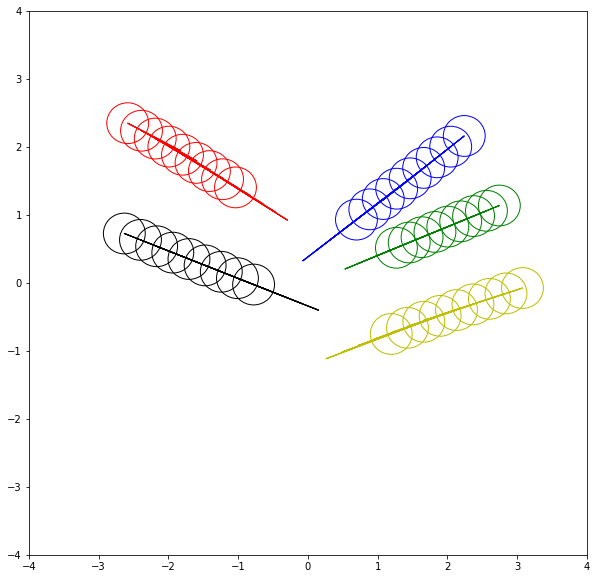

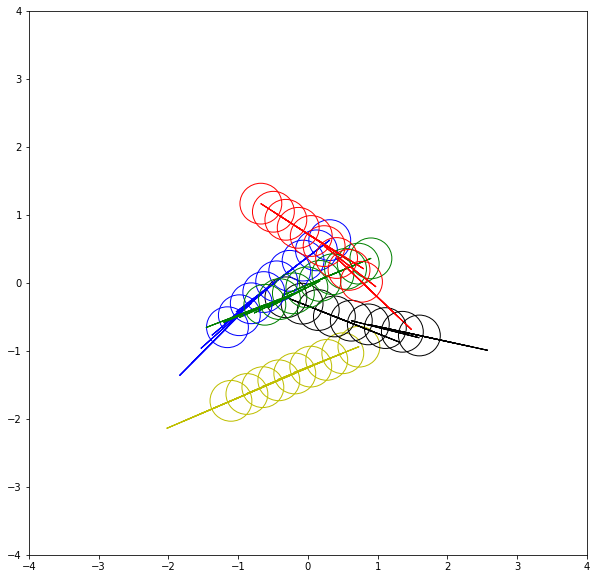

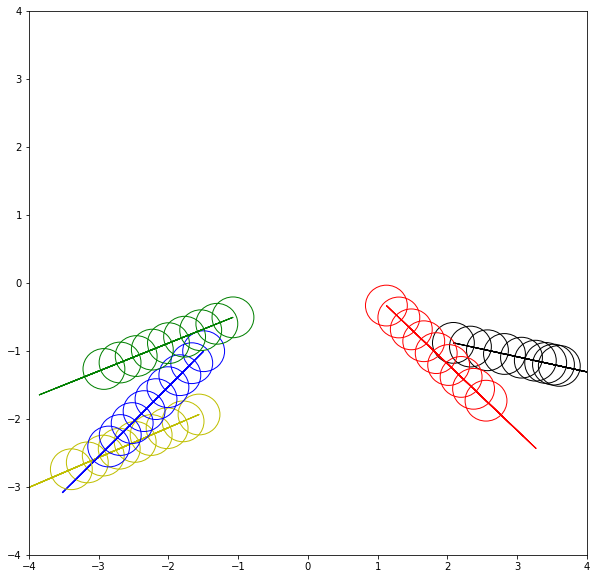

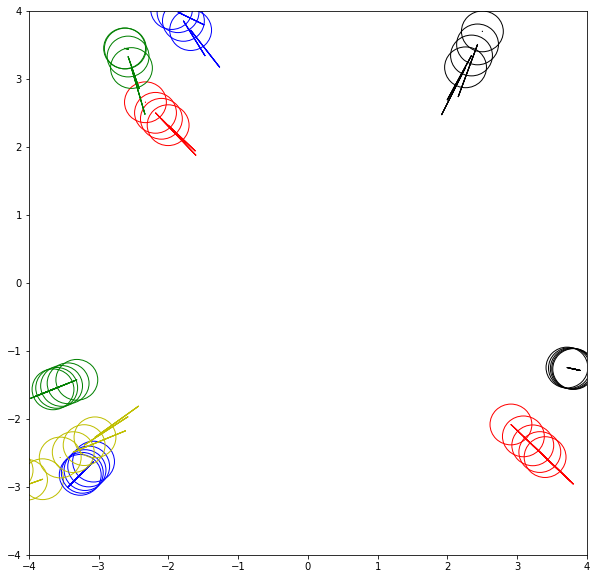

In [5]:
# ---------------  Ground Truth  -------------
i=0
for data in train_loader:
    i+=1
    x,_,y,_ = data
    render_truth(x[1:],0.3)
    if i == 4:
        break

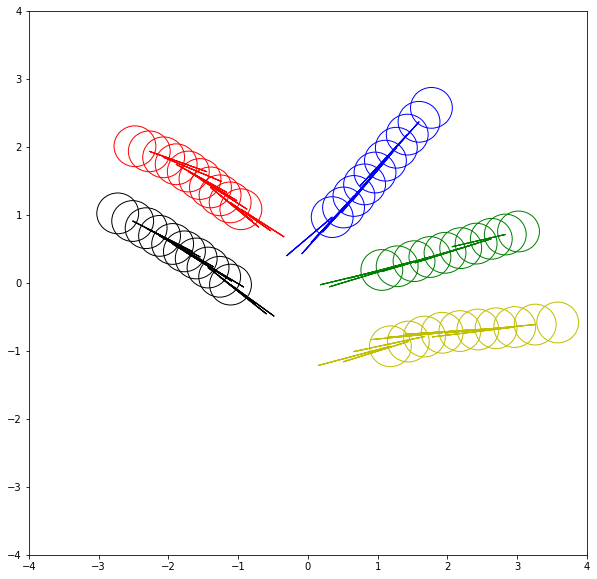

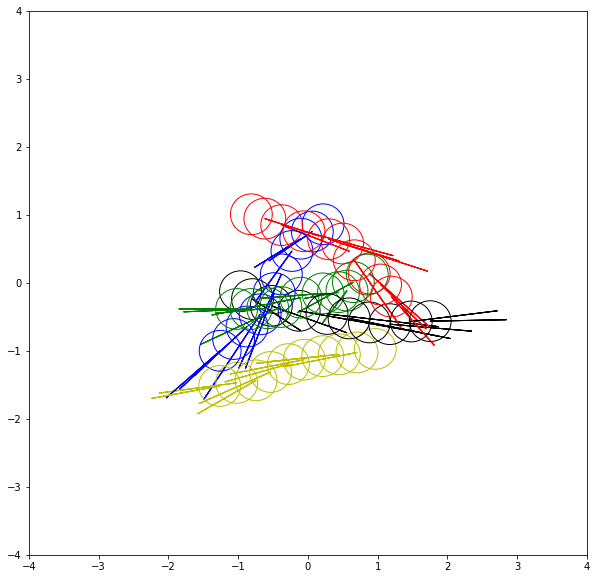

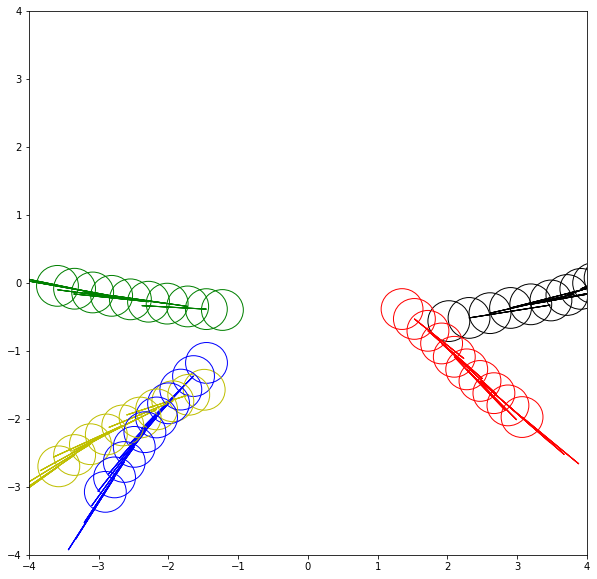

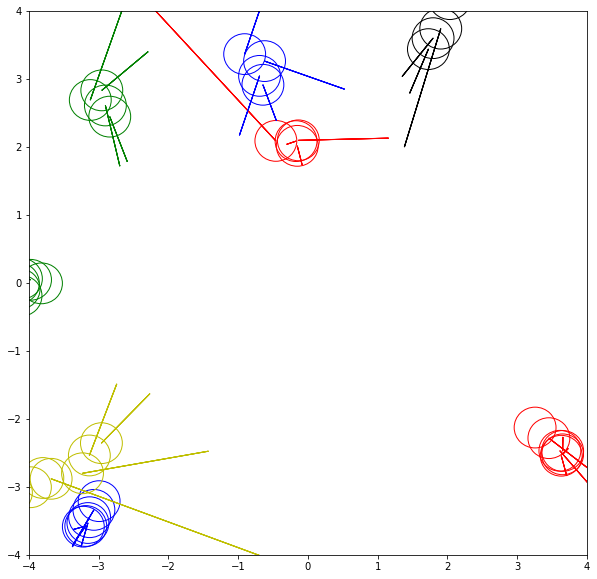

In [6]:
# ---------------  Prediction  -------------
model = autoencoder(num_human,drop_rate).cuda()
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
i=0
for data in train_loader:
    i+=1
    x,_,y,_ = data
    y = y[:,:,:2]
    x = x.view(x.size(0), -1)
    x = Variable(x).cuda()
    output=model(x)
    output = torch.reshape(output,(-1,5,2))
    render(output.tolist(),0.3)
    if i==4:
        break